In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(42)

In [3]:
import re

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']         = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']         = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age']        = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;



/var/folders/bp/xg1jdzw13hbccf7_p5zg7b040000gn/T/ipykernel_99652/64541663.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1


In [6]:
## Calculate the percentage of travelers in each class and plot this percentage graphically.
vc = train['Survived'].value_counts().to_frame().reset_index()
vc['percentage'] = vc['Survived'].apply(lambda x : round(100*float(x)/len(train), 2))
vc = vc.rename(columns= {'index' : 'Target', 'Survived' : 'Count'})
vc

,Target,Count,percentage
0,0,549,61.62
1,1,342,38.38


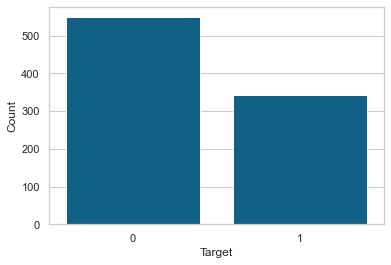

In [7]:
ax = sns.barplot(x='Target', y='Count', data=vc, color='#006699')

In [8]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [15]:
## Divide the data set into train and test, separating X and y

X = train.drop(["Survived"], axis=1)
y = train["Survived"]
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [16]:
## Define a model of Autoencoders to process the data
## Compile the model with the adadelta optimizer and the MSE loss metrics

## input layer 
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)
output_layer = Dense(X.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [17]:
## Apply MinMaxScaler transformation to get X_train and X_test
from sklearn.preprocessing import StandardScaler

sc = preprocessing.MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [18]:
## Divide the transformed data set according to whether they died or not.

X_train_perished, X_train_survived = X_train[y_train == 0], X_train[y_train == 1]
X_test_perished, X_test_survived = X_test[y_test == 0], X_test[y_test == 1]

In [19]:

autoencoder.fit(X_train_perished, X_train_perished, epochs = 20, shuffle = True, 
                validation_data=(X_test_perished, X_test_perished))

Epoch 1/20


2022-07-24 17:38:07.593060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 3s 53ms/step - loss: 0.2612 - val_loss: 0.2664
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.2606 - val_loss: 0.2657
Epoch 3/20
 1/14 [=>............................] - ETA: 0s - loss: 0.2558

2022-07-24 17:38:09.163771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 8ms/step - loss: 0.2599 - val_loss: 0.2650
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2593 - val_loss: 0.2643
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2586 - val_loss: 0.2636
Epoch 6/20
14/14 [==============================] - 0s 11ms/step - loss: 0.2579 - val_loss: 0.2629
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 0.2573 - val_loss: 0.2622
Epoch 8/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2566 - val_loss: 0.2615
Epoch 9/20
14/14 [==============================] - 0s 7ms/step - loss: 0.2559 - val_loss: 0.2607
Epoch 10/20
14/14 [==============================] - 0s 7ms/step - loss: 0.2552 - val_loss: 0.2599
Epoch 11/20
14/14 [==============================] - 0s 7ms/step - loss: 0.2545 - val_loss: 0.2592
Epoch 12/20
14/14 [==============================] - 0s 7ms/step - loss: 0.2538 - val_loss: 0.2584
Epoch 13/20
14/14 [========

In [20]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [21]:
X_train_hid_rep = hidden_representation.predict(X_train)
X_tes_hid_rep = hidden_representation.predict(X_test)

7/7 [==============================] - 0s 2ms/step


2022-07-24 17:38:32.170561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [22]:
clf = LogisticRegression().fit(X_train_hid_rep, y_train)
pred_y = clf.predict(X_tes_hid_rep)

print (classification_report(y_test, pred_y))
print (accuracy_score(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       131
           1       0.80      0.72      0.75        92

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223

0.8071748878923767
